In [60]:
from PIL import Image
import pandas as pd
import numpy as np
import os
from random import shuffle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras
import tensorflow
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, InputLayer, BatchNormalization
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras.constraints import max_norm
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# custom functions
from helpers import set_target, check_dist, merge_target, train_test, predict

In [3]:
import cv2
from mtcnn import MTCNN

# Bring in the dataframe contain all photos

In [4]:
df_all = pd.read_pickle('pickles/images_features_emotions_target.pkl')

In [ ]:
df_mini = df_all.sample(n=1000, random_state=0)

In [49]:
# 51 percent of photos are NOT popular

check_dist(df_all, 'is_popular')

0.5124986355201397

In [6]:
df_all.shape

(18322, 45)

# Model

In [8]:
X_train, X_test, y_train_cat, y_train, y_test = train_test(df_all, 'is_popular')

## Running initial model on the popularity target

In [10]:
NN = Sequential()
NN.add(InputLayer(input_shape=X_train.shape[1:])) 

# Conv block 1.  
NN.add(Conv2D(filters=32, kernel_size=3, kernel_constraint=max_norm(3), 
              bias_constraint=max_norm(3), activation='elu', padding='same')) 
NN.add(MaxPooling2D(2))
NN.add(BatchNormalization())
NN.add(Dropout(0.2))

# Conv block 2
NN.add(Conv2D(filters=64, kernel_size=3, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), 
              activation='elu', padding='same'))
NN.add(MaxPooling2D(2))
NN.add(BatchNormalization())
NN.add(Dropout(0.3))

# Conv block 3
NN.add(Conv2D(filters=128, kernel_size=3, kernel_constraint=max_norm(3), bias_constraint=max_norm(3), 
              activation='elu', padding='same'))
NN.add(MaxPooling2D(2))
NN.add(BatchNormalization())
NN.add(Dropout(0.4))

# Conv block 4
NN.add(Conv2D(filters=64, kernel_size=3, kernel_constraint=max_norm(3), bias_constraint=max_norm(3),
              activation='elu', padding='same'))
NN.add(MaxPooling2D(2))
NN.add(BatchNormalization())
NN.add(Dropout(0.5))

# Conv block 5
NN.add(Conv2D(filters=32, kernel_size=3, kernel_constraint=max_norm(3), bias_constraint=max_norm(3),
              activation='elu', padding='same'))
NN.add(MaxPooling2D(2))
NN.add(BatchNormalization())

# # NN.add(GlobalAveragePooling2D())

# Fully connected block - flattening followed by dense and output layers
NN.add(Flatten())
NN.add(Dense(8,  activation='elu'))
NN.add(BatchNormalization())
NN.add(Dropout(0.5))

NN.add(Dense(2,activation='sigmoid'))  # 2 target classes, output layer

NN.compile(
    loss='binary_crossentropy',
    optimizer=tensorflow.keras.optimizers.Adam(lr=0.005),
    metrics=['accuracy'],
)


# # image augmentation (exlcuding horizontal flip because I had already done that when I loaded the data)
# train_datagen = ImageDataGenerator(rescale=1./255,
#     rotation_range=90,
#     vertical_flip=True,
#     validation_split=0.25)

# # only applying scaling to the validation set
# val_datagen = ImageDataGenerator(rescale=1./255)

# # one hot encoding the targets
# y_train_cat = np_utils.to_categorical(y_train, num_classes=2)
# y_val_cat = np_utils.to_categorical(y_val, num_classes=2)

# # training and validation gerators
# train_gen = train_datagen.flow(X_train, y_train_cat)
# val_gen = val_datagen.flow(X_val, y_val_cat)


# callbacks
es = EarlyStopping(patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2,
                              patience=5, cooldown=5, min_lr=0.00001)

NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25, callbacks=[es, reduce_lr])


# NN.fit_generator(train_gen, steps_per_epoch=100, epochs=100, callbacks=[es, reduce_lr], 
#                  verbose=1, validation_data=val_gen, validation_steps=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

Epoch 00029: early stopping


## Predict on test set

In [14]:
predict(NN, y_test, X_test)

Accuracy: 0.7091405184174625
Dist of Preds:
0    2132
1    1533
dtype: int64


## Save the model for flask app

In [15]:
NN.save('best_model.h5')

# Feature Extraction (for blog)

(1, 64, 64, 32)
(1, 64, 64, 32)
(1, 64, 64, 32)
(1, 64, 64, 64)
(1, 32, 32, 64)
(1, 32, 32, 64)
(1, 32, 32, 64)
(1, 32, 32, 128)
(1, 16, 16, 128)
(1, 16, 16, 128)
(1, 16, 16, 128)
(1, 16, 16, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 8, 8, 32)
(1, 4, 4, 32)
(1, 4, 4, 32)
(1, 512)
(1, 8)
(1, 8)
(1, 8)
(1, 2)


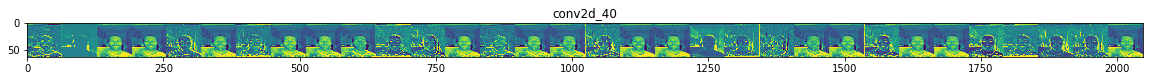

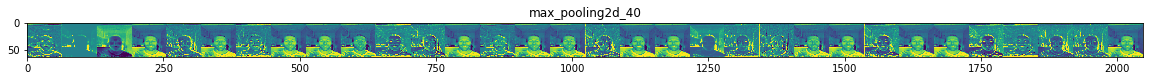

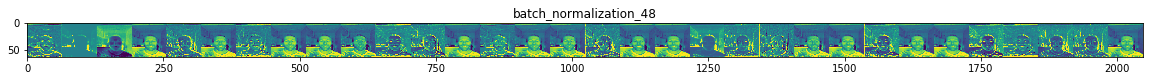

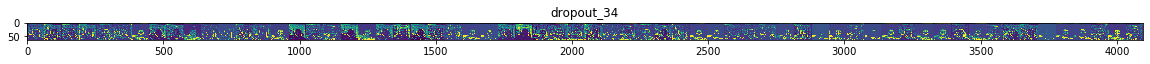

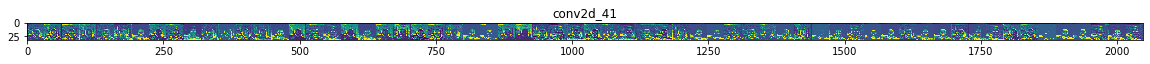

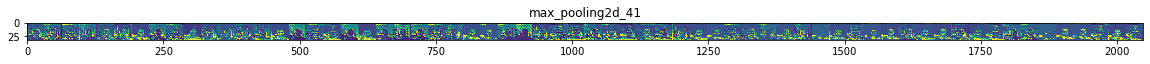

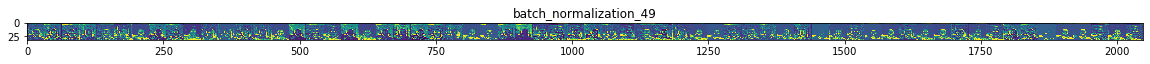

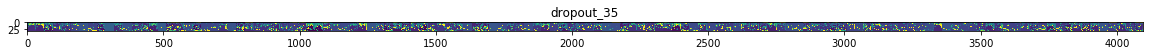

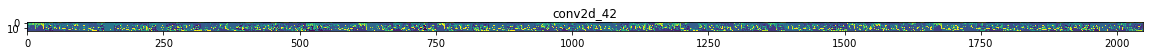

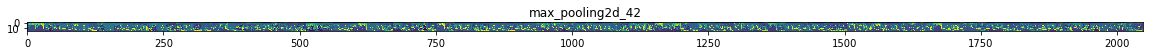

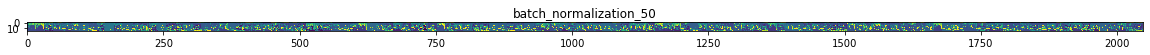

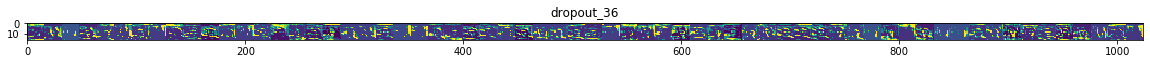

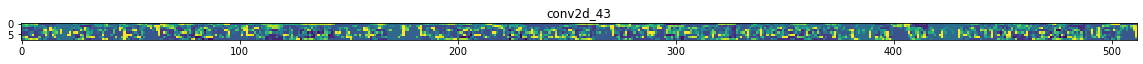

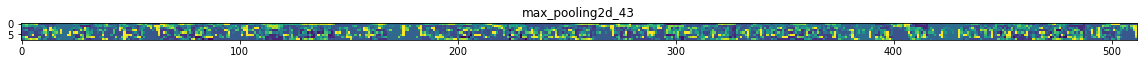

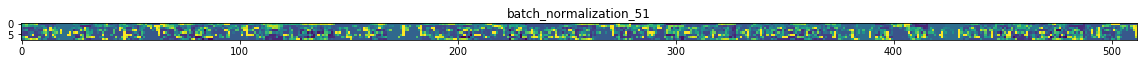

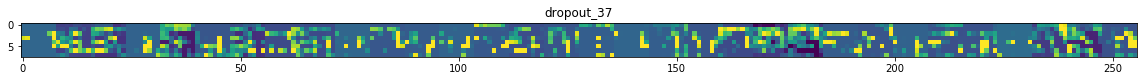

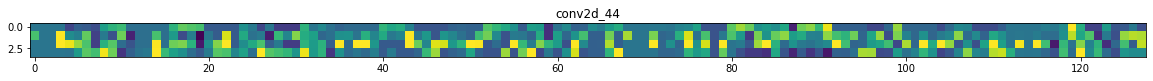

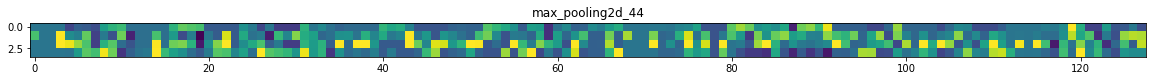

In [140]:
img_path='test_images/nice.jpg' #me

# Define a new Model
successive_outputs = [layer.output for layer in NN.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tensorflow.keras.models.Model(inputs = NN.input, outputs = successive_outputs)

#Load the input image
img = load_img(img_path, target_size=(128, 128))
# Convert ht image to Array of dimension (128,128,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0

# run input image through our vislauization network
successive_feature_maps = visualization_model.predict(x)

# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in NN.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [16]:
feature_extractor = \
    tensorflow.keras.models.Model(inputs=NN.input, outputs= NN.layers[-4].output) 

X_train_NN_features = feature_extractor.predict(X_train)
X_test_NN_features = feature_extractor.predict(X_test)

In [46]:
X_train_NN_features[0]

array([20.865181, 43.41783 , 44.570976, 46.911896, 37.122658, 19.621222,
       19.229282, 27.445305], dtype=float32)

Text(0.5, 1.0, 'NN Learned 2D Feature Representation')

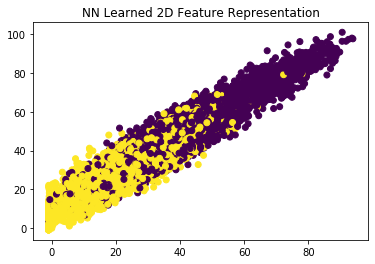

In [27]:
plt.scatter(X_train_NN_features[:,0], X_train_NN_features[:,1], c = y_train)
plt.title('NN Learned 2D Feature Representation')

# Transfer Learning (unsuccessful)

In [21]:
from keras.models import Model
from keras.applications import mobilenet_v2

In [23]:
from keras.applications.resnet50 import ResNet50

In [29]:
# note we exclude the final dense layers by setting include_top=False,
# and add new ones to train from scratch below

# base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(306,306,3)) 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3)) 

In [30]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) # flatten from convolution tensor output 
x = Dense(4, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(2, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x) # should match # of classes predicted

es = EarlyStopping(patience=30, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', verbose=1, factor=0.2,
                              patience=5, cooldown=5, min_lr=0.0001)

# define formal model object to train and compile it as usual
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [31]:
model.fit(X_train, y_train_cat, epochs=5, verbose=1, validation_split=0.25, callbacks=[es, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 200 samples
Epoch 1/5
600/600 [==============================] - 30s 50ms/step - loss: 0.7203 - accuracy: 0.5150 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 2/5
600/600 [==============================] - 31s 52ms/step - loss: 0.6971 - accuracy: 0.4983 - val_loss: 0.6929 - val_accuracy: 0.5200
Epoch 3/5
600/600 [==============================] - 32s 54ms/step - loss: 0.6886 - accuracy: 0.4967 - val_loss: 0.6930 - val_accuracy: 0.5200
Epoch 4/5
600/600 [==============================] - 31s 51ms/step - loss: 0.6848 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5200
Epoch 5/5
600/600 [==============================] - 30s 50ms/step - loss: 0.6798 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4800
